<a href="https://colab.research.google.com/github/HannaKi/kandi/blob/master/sentiment_analysis_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you're opening this Notebook on colab, you will probably need to install the most recent versions of 🤗 Transformers and 🤗 Datasets. We will also need `scipy` and `scikit-learn` for some of the metrics. Uncomment the following cell and run it.

In [1]:
! pip --quiet install git+https://github.com/huggingface/transformers.git
! pip --quiet install git+https://github.com/huggingface/datasets.git
! pip --quiet install scipy sklearn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 12.6 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 41.7 MB/s 
     |████████████████████████████████| 6.5 MB 34.9 MB/s 
     |████████████████████████████████| 212 kB 8.6 MB/s 
     |████████████████████████████████| 134 kB 47.5 MB/s 
     |████████████████████████████████| 1.1 MB 45.2 MB/s 
     |████████████████████████████████| 271 kB 44.7 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 50.4 MB/s 


Make sure your version of Transformers is at least 4.8.1 since the functionality was introduced in that version:

In [2]:
import transformers

print(transformers.__version__)

4.18.0.dev0


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/text-classification).

# Fine-tuning a model on a text classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a text classification task of the [GLUE Benchmark](https://gluebenchmark.com/).

The GLUE Benchmark is a group of nine classification tasks on sentences or pairs of sentences which are:


- [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) Determine if the sentence has a positive or negative sentiment.


In [3]:
task = "sst2"
model_checkpoint ="bert-base-cased" # name from Hugging Face repository
batch_size = 6 # to not to OOM
TRAIN = False # by assumption use the model finetuned and saved to Google Drive. 

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

https://github.com/huggingface/datasets/tree/master/datasets/imdb: 

label: a classification label, with possible values including neg (0), pos (1).

In [4]:
#from datasets import load_dataset, load_metric
import datasets

In [5]:
train, test = datasets.load_dataset("imdb", split=["train", "test"], download_mode='force_redownload')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dataset = datasets.DatasetDict({'train': train, 'test': test})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [7]:
for i in range(0,200,40):
  print(dataset["train"]["label"][i], "\t", dataset["train"]["text"][i])

0 	 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between,

In [9]:
import numpy as np
num_labels=len(np.unique(dataset["train"]["label"])) # luokkien lukumäärä
print(np.unique(dataset["train"]["label"]))
num_labels

[0 1]


2

In [10]:
dataset["train"] = dataset["train"].filter(lambda example, idx: idx % 20 == 0, with_indices=True)
# split test data to validation and test and downsample both
dataset["validation"] = dataset["test"].filter(lambda example, idx: idx % 2 == 0, with_indices=True).filter(lambda example, idx: idx % 30 == 0, with_indices=True)
dataset["test"] = dataset["test"].filter(lambda example, idx: idx % 2 != 0, with_indices=True).filter(lambda example, idx: idx % 30 == 0, with_indices=True)
# if index is divisible with 10, select the instance

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1250
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 417
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 417
    })
})

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

You can directly call this tokenizer on one sentence or a pair of sentences:

In [ ]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [101, 8667, 117, 1142, 1141, 5650, 106, 102, 1262, 1142, 5650, 2947, 1114, 1122, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

In [13]:
# task_to_keys = {
#     "cola": ("sentence", None),
#     "mnli": ("premise", "hypothesis"),
#     "mnli-mm": ("premise", "hypothesis"),
#     "mrpc": ("sentence1", "sentence2"),
#     "qnli": ("question", "sentence"),
#     "qqp": ("question1", "question2"),
#     "rte": ("sentence1", "sentence2"),
#     "sst2": ("text", None),
#     "stsb": ("sentence1", "sentence2"),
#     "wnli": ("sentence1", "sentence2"),
# }

# # task = "sst2"

We can double check it does work on our current dataset:

In [16]:
# sentence1_key, sentence2_key = task_to_keys[task]
# if sentence2_key is None:
#     print(f"Sentence: {dataset['train'][0][sentence1_key]}")
# else:
#     print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
#     print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

We can them write the function that will preprocess our samples. We just feed them to the `tokenizer` with the arguments `truncation=True` and `padding='longest`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model, and all inputs will be padded to the maximum input length to give us a single input array. A more performant method that reduces the number of padding tokens is to write a generator or `tf.data.Dataset` to only pad each *batch* to the maximum length in that batch, but most GLUE tasks are relatively quick on modern GPUs either way.

In [17]:
# def preprocess_function(examples):
#     if sentence2_key is None:
#         return tokenizer(examples[sentence1_key], truncation=True)
#     return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [18]:
# preprocess_function(dataset["train"][:5])

{'input_ids': [[101, 146, 12765, 146, 6586, 140, 19556, 19368, 13329, 118, 162, 21678, 2162, 17056, 1121, 1139, 1888, 2984, 1272, 1104, 1155, 1103, 6392, 1115, 4405, 1122, 1165, 1122, 1108, 1148, 1308, 1107, 2573, 119, 146, 1145, 1767, 1115, 1120, 1148, 1122, 1108, 7842, 1118, 158, 119, 156, 119, 10148, 1191, 1122, 1518, 1793, 1106, 3873, 1142, 1583, 117, 3335, 1217, 170, 5442, 1104, 2441, 1737, 107, 6241, 107, 146, 1541, 1125, 1106, 1267, 1142, 1111, 1991, 119, 133, 9304, 120, 135, 133, 9304, 120, 135, 1109, 4928, 1110, 8663, 1213, 170, 1685, 3619, 3362, 2377, 1417, 14960, 1150, 3349, 1106, 3858, 1917, 1131, 1169, 1164, 1297, 119, 1130, 2440, 1131, 3349, 1106, 2817, 1123, 2209, 1116, 1106, 1543, 1199, 3271, 1104, 4148, 1113, 1184, 1103, 1903, 156, 11547, 1162, 1354, 1164, 2218, 1741, 2492, 1216, 1112, 1103, 4357, 1414, 1105, 1886, 2492, 1107, 1103, 1244, 1311, 119, 1130, 1206, 4107, 8673, 1105, 6655, 10552, 3708, 2316, 1104, 8583, 1164, 1147, 11089, 1113, 4039, 117, 1131, 1144, 2673, 

In [31]:
def preprocess_function(examples):
    return tokenizer(examples[sentence1_key], truncation=True)

preprocess_function(dataset["train"][:5])

{'input_ids': [[101, 146, 12765, 146, 6586, 140, 19556, 19368, 13329, 118, 162, 21678, 2162, 17056, 1121, 1139, 1888, 2984, 1272, 1104, 1155, 1103, 6392, 1115, 4405, 1122, 1165, 1122, 1108, 1148, 1308, 1107, 2573, 119, 146, 1145, 1767, 1115, 1120, 1148, 1122, 1108, 7842, 1118, 158, 119, 156, 119, 10148, 1191, 1122, 1518, 1793, 1106, 3873, 1142, 1583, 117, 3335, 1217, 170, 5442, 1104, 2441, 1737, 107, 6241, 107, 146, 1541, 1125, 1106, 1267, 1142, 1111, 1991, 119, 133, 9304, 120, 135, 133, 9304, 120, 135, 1109, 4928, 1110, 8663, 1213, 170, 1685, 3619, 3362, 2377, 1417, 14960, 1150, 3349, 1106, 3858, 1917, 1131, 1169, 1164, 1297, 119, 1130, 2440, 1131, 3349, 1106, 2817, 1123, 2209, 1116, 1106, 1543, 1199, 3271, 1104, 4148, 1113, 1184, 1103, 1903, 156, 11547, 1162, 1354, 1164, 2218, 1741, 2492, 1216, 1112, 1103, 4357, 1414, 1105, 1886, 2492, 1107, 1103, 1244, 1311, 119, 1130, 1206, 4107, 8673, 1105, 6655, 10552, 3708, 2316, 1104, 8583, 1164, 1147, 11089, 1113, 4039, 117, 1131, 1144, 2673, 

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [19]:
pre_tokenizer_columns = set(dataset["train"].features)
encoded_dataset = dataset.map(preprocess_function, batched=True) # atched=True to encode the texts by batches together. 
# This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['attention_mask', 'input_ids', 'token_type_ids']


In [ ]:
encoded_dataset["train"].features["label"]

ClassLabel(num_classes=2, names=['neg', 'pos'], id=None)

you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Finally, we convert our datasets to `tf.data.Dataset`. There's a built-in method for this, so all you need to do is specify the columns you want (both for the inputs and the labels), whether the data should be shuffled, the batch size, and an optional collation function, that controls how a batch of samples is combined.

We'll need to supply a `DataCollator` for this. The `DataCollator` handles grouping each batch of samples together, and different tasks will require different data collators. In this case, we will use the `DataCollatorWithPadding`, because our samples need to be padded to the same length to form a batch. Remember to supply the `return_tensors` argument too - our data collators can handle multiple frameworks, so you need to be clear that you want TensorFlow tensors back.

In [20]:
from transformers import DataCollatorWithPadding

# Data_collator controls how a batch of samples is combined.
# Use DataCollatorWithPadding, because our samples need to be padded to the same length to form a batch. 
# Remember to supply the return_tensors argument too - our data collators can handle multiple frameworks, so you need to be clear that you want TensorFlow tensors back.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf") 

tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["validation"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_test_dataset = encoded_dataset["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [22]:
encoded_dataset["test"]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 417
})

In [23]:
tf_test_dataset

<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Metrics

In [24]:
# See availabe metrics: https://huggingface.co/metrics

metric = datasets.load_metric('accuracy')
metric

Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions: Predicted labels, as returned by a model.
    references: Ground truth labels.
    normalize: If False, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    sample_weight: Sample weights.
Returns:
    accuracy: Accuracy score.
Examples:

    >>> accuracy_metric = datasets.load_metric("accuracy")
    >>> results = accuracy_metric.compute(references=[0, 1], predictions=[0, 1])
    >>> print(results)
    {'accuracy': 1.0}
""", stored examples: 0)


## TODO:  Naive baseline

Let's make a really naive baseline for the upcoming CNN classifiers. I could build a linear baseline classifier but I do not want to do laborious feature extraction from the images just for the baseline classifier. So the baseline will be simply guessing the most common class in the training data, which is 12 percent for class 8


## Fine-tuning the model

In [25]:
# To connect Google account to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
# cd gdrive/MyDrive/bachelor_thesis
# mkdir model_checkpoints
# ls

In [26]:
file_path="/content/drive/MyDrive/bachelor_thesis/model_checkpoints/model.hdf5"

- download the pretrained model and fine-tune it (`TFAutoModelForSequenceClassification` class). 
  - specify the number of labels for our problem 
- get the appropriate loss function (SparseCategoricalCrossentropy)


In [27]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels = dataset["train"].features["label"].num_classes
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# from_logits: Whether y_pred is expected to be a logits tensor. 
# By default, we assume that y_pred encodes a probability distribution (from_logits=False). 

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). **This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights**, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

- create a `AdamW` optimizer with weight and learning rate decay. Note that because it decays the learning rate over the course of training, it needs to know how many batches it will see during training.
- L2 regularization (a.k.a. weight decay, ridge regression) penalizes model for being too complex. The regularization penalty multiplied by weight is added to the total loss of the network. Hence we are punishing for higher weights and expect that none of the model parameters is drastically more important than the other ones.

In [28]:
from transformers import create_optimizer

num_epochs = 2#5
batches_per_epoch = len(encoded_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer, loss=loss)

The last thing to define is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits.

let's wrap this metric computation function in a KerasMetricCallback. This callback will compute the metric on the validation set each epoch, including printing it and logging it for other callbacks like TensorBoard and EarlyStopping.

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback
import numpy as np

def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    predictions = np.argmax(predictions, axis=1) # argmax of our predicted logits (indeksi, jossa on ennusteen suuri arvo. Indeksi = luokka)
    return metric.compute(predictions=predictions, references=labels) # call for the metrics instantiated in chapter "Metrics"

# add Keras metrics to get live readouts during training 
metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_dataset
)

We can now finetune our model by just calling the `fit` method. Be sure to pass the TF datasets, and not the original datasets! We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! Make sure to change the `username` if you do. If you don't want to do this, simply remove the callbacks argument in the call to `fit()`.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime

if TRAIN:

  # tensorboard_callback = TensorBoard(log_dir="./text_classification_model_save/logs")

  # log_dir = "/content/drive/MyDrive/bachelor_thesis/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


  model_checkpoint_callback = ModelCheckpoint(filepath=file_path, 
                          monitor='val_loss', 
                          verbose=1, 
                          save_best_only=True, 
                          save_weights_only=True, # only the weights are saved. To use them a model is needed but it can be saved elsewhere or restored from this notebook
                          save_freq='epoch', # save after every epoch
                          mode='auto')

  # Not needed with save checkpoint
  # stop_callback = EarlyStopping(monitor = 'val_loss', 
  #                         patience=2, # how many epochs to wait for the metrics to improve
  #                         verbose=1, 
  #                         mode='auto', 
  #                         baseline=None, 
  #                         restore_best_weights=True)

  callbacks = [metric_callback, model_checkpoint_callback]#, stop_callback]

  model.fit(
      tf_train_dataset,
      validation_data=tf_validation_dataset,
      verbose=1,
      epochs=1, #3,
      callbacks=[callbacks],
  )

else: 
  model.load_weights(file_path)

208/208 [==============================] - ETA: 0s - loss: 0.1406
Epoch 1: val_loss improved from inf to 0.26289, saving model to /content/drive/MyDrive/bachelor_thesis/model_checkpoints/model.hdf5
208/208 [==============================] - 381s 2s/step - loss: 0.1406 - val_loss: 0.2629 - accuracy: 0.9041


Predict with test data and calculate test accuracy


In [30]:
predictions = model.predict(tf_test_dataset)["logits"]
predictions[:5]

array([[ 0.35076588, -1.0008607 ],
       [-1.9121771 ,  1.7757233 ],
       [ 0.3078607 , -1.1297804 ],
       [ 1.5143834 , -1.7531371 ],
       [ 1.7868869 , -1.8565452 ]], dtype=float32)

In [32]:
import numpy as np

preds=np.argmax(predictions, axis=1)
true=np.array(encoded_dataset["test"]['label'])
metric.compute(predictions=preds, references=true)

{'accuracy': 0.894484412470024}

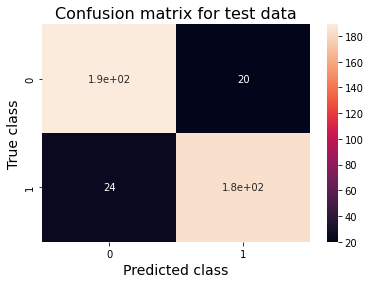

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Columns represent the predicted labels and the rows represent the real labels

cf_mat = tf.math.confusion_matrix(
    true, preds, num_classes=None, weights=None, dtype=tf.dtypes.int64,
    name=None
)
def plot_cf_matrix(mat):
  sns.heatmap(mat, annot=True)
  plt.title("Confusion matrix for test data", fontsize = 16)
  plt.ylabel("True class", fontsize = 14)
  plt.xlabel("Predicted class", fontsize = 14)


plot_cf_matrix(cf_mat)

## SHAP

API: https://github.com/slundberg/shap/blob/master/docs/api.rst#id1

https://github.com/slundberg/shap

https://github.com/slundberg/shap#natural-language-example-transformers

https://github.com/slundberg/shap/blob/master/notebooks/text_examples/sentiment_analysis/Positive%20vs.%20Negative%20Sentiment%20Classification.ipynb

ks. ehkä myös: https://github.com/slundberg/shap/tree/master/notebooks/text_examples/sentiment_analysis


In [34]:
! pip --quiet install shap

     |████████████████████████████████| 564 kB 11.3 MB/s 


Now that the model has been defined we can use [a transformer pipeline](https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html?highlight=return_all_scores#)

In [42]:
import shap
# https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html?highlight=return_all_scores

# classifier = transformers.pipeline('sentiment-analysis', return_all_scores=True)
# classifier(short_data[:2])

# Now that the model has been fefined we can use transformer pipeline 
classifier = transformers.pipeline(task='sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=True)
short_data = [v[:300] for v in dataset["test"]["text"][:20]] # first 500 letters from the first 20 test split texts
classifier(short_data[:20]) # pipeline predictions for the 2 first samples in the "short_data"
# Labels need to be int for the model, thus 'LABEL_0' and 'LABEL_1'
# TODO: fix labels

[[{'label': 'LABEL_0', 'score': 0.015943970531225204},
  {'label': 'LABEL_1', 'score': 0.9840559959411621}],
 [{'label': 'LABEL_0', 'score': 0.024413587525486946},
  {'label': 'LABEL_1', 'score': 0.9755864143371582}],
 [{'label': 'LABEL_0', 'score': 0.43950480222702026},
  {'label': 'LABEL_1', 'score': 0.5604951977729797}],
 [{'label': 'LABEL_0', 'score': 0.9548459649085999},
  {'label': 'LABEL_1', 'score': 0.04515407234430313}],
 [{'label': 'LABEL_0', 'score': 0.9686471223831177},
  {'label': 'LABEL_1', 'score': 0.03135286644101143}],
 [{'label': 'LABEL_0', 'score': 0.9664409756660461},
  {'label': 'LABEL_1', 'score': 0.033559009432792664}],
 [{'label': 'LABEL_0', 'score': 0.9607104063034058},
  {'label': 'LABEL_1', 'score': 0.03928964585065842}],
 [{'label': 'LABEL_0', 'score': 0.01162712275981903},
  {'label': 'LABEL_1', 'score': 0.9883728623390198}],
 [{'label': 'LABEL_0', 'score': 0.930213451385498},
  {'label': 'LABEL_1', 'score': 0.06978660076856613}],
 [{'label': 'LABEL_0', 'sc

In [43]:
# define the explainer
# https://github.com/slundberg/shap
# https://github.com/slundberg/shap#natural-language-example-transformers
# https://github.com/slundberg/shap/blob/master/notebooks/text_examples/sentiment_analysis/Positive%20vs.%20Negative%20Sentiment%20Classification.ipynb

# ehkä myös: https://github.com/slundberg/shap/tree/master/notebooks/text_examples/sentiment_analysis
explainer = shap.Explainer(classifier)

In [50]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:4])

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 3/4 [06:13<01:31, 91.26s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 4/4 [09:15<00:00, 129.18s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [12:39, 189.78s/it]


In [51]:
shap.plots.text(shap_values[:,:,"LABEL_1"]) # label value 1 is positive for the IMDB data

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [49]:
sentence = ["What a great movie! ...if you have no taste."]
classifier(sentence) # classifier is pretty sure this rating is positive. Why?

[[{'label': 'LABEL_0', 'score': 0.14405086636543274},
  {'label': 'LABEL_1', 'score': 0.8559491634368896}]]

In [48]:
shap_values = explainer(sentence)
shap.plots.text(shap_values[0, :, 'LABEL_1']) # from below we can see, that word "great" has been given great emphasis

In [ ]:
'''
print(model.layers) # kaikki kerrokset
print(len(model.layers))
model.layers[0] # Bert
model.layers[1] # Dropout
model.layers[2] # Dense # Viimeinen eli sama kuin model.layers[-1]
'''

In [ ]:
'''
print(type(dataset["train"][:100])) # dict ei kelpaa, joten poimitaan 

for k, v in dataset["train"][:100].items():
  print(k, v)

print(type(dataset["train"][:100]['text']))

testi= [list(x) for x in dataset["train"][:100]['text']] # nested list
print(type(testi))
print(type(testi[0]))
'''

In [ ]:
'''
model.outputs = np.array([1,2]) # Asetetaan mallin output: Tässä vain jokin vektori, jonka pituus on 
# XXXX (koska malli tuottaa jokaiselle syötteelle )
# Ks. tarkemmin shap-kirjaston lähdekoodi tiedostossa tf_utils.py ja rivi 85

# we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model, x_train[:100])
# explainer = shap.DeepExplainer(model, dataset["train"][:100]['sentence']) # lista syötteen tekstejä
explainer = shap.DeepExplainer(model, testi) # lista syötteen tekstejä


# SHAP requires tensor outputs from the classifier, and explanations works best in additive spaces so we transform the probabilities into logit values (information values instead of probabilites).


# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
# shap_values = explainer.shap_values(x_test[:10])
shap_values = explainer.shap_values(dataset["test"][:10]['sentence'])

'''